In [4]:
import gxipy as gx
import cv2
import imutils
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

from shapedetector import ShapeDetector

In [5]:
# 从大恒水星2相机获取图片
device_manager = gx.DeviceManager()

dev_num, dev_info_list = device_manager.update_device_list()

# 未检测到设备
if dev_num == 0:
    print("Number of enumerated devices is 0")

else:
    print(dev_info_list)

# 相机对象（取index为1的设备）
cam = device_manager.open_device_by_index(1)

[{'index': 1, 'vendor_name': 'Daheng Imaging', 'model_name': 'MER-201-25GM-P', 'sn': 'QN0200050042', 'display_name': 'MER-201-25GM-P(192.168.125.11[00-21-49-02-07-D3])', 'device_id': 'MER-201-25GM-P(00-21-49-02-07-D3)', 'user_id': '', 'access_status': 1, 'device_class': 2, 'mac': '00-21-49-02-07-D3', 'ip': '192.168.125.11', 'subnet_mask': '255.255.255.0', 'gateway': '0.0.0.0', 'nic_mac': 'B0-25-AA-2B-23-93', 'nic_ip': '192.168.125.2', 'nic_subnet_mask': '255.255.255.0', 'nic_gateWay': '192.168.125.1', 'nic_description': 'Realtek PCIe GbE Family Controller #2'}]


In [6]:
# 开始采集图像
cam.stream_on()

raw_image = cam.data_stream[0].get_image()

if raw_image is None:
    print("图像采集失败")

else:
    print("Frame ID: {} | Height: {} | Width: {}".format(
        raw_image.get_frame_id(), raw_image.get_height(), raw_image.get_width()))

numpy_image = raw_image.get_numpy_array()
if numpy_image is None:
    print("NumPy数组转换失败")

# 停止采集图像
cam.stream_off()

# 存储图片
img_filename = "ugrow_" + datetime.now().strftime("%Y%m%d%H%M%S")
cv2.imwrite("images/{}.jpg".format(img_filename), numpy_image)

# 读取图片
image = cv2.imread("images/{}.jpg".format(img_filename))

Frame ID: 1 | Height: 1236 | Width: 1628


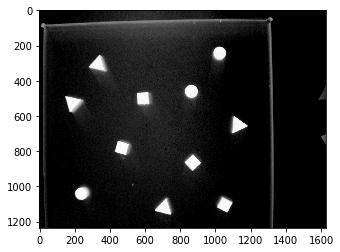

In [7]:
plt.set_cmap('binary')
plt.imshow(numpy_image)

In [8]:
# 灰度化
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 高斯模糊
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# 二值化
_, thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)

In [9]:
cnts = cv2.findContours(255-thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [10]:
sd = ShapeDetector()

In [11]:
output_image = image.copy()
detections = []

for c in cnts:
    
    shape = sd.detect(c)
    shape_dict = {"circle":0, "triangle":3, "rectangle":4}

    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    detections.append([shape_dict[shape],cY,cX])

    c = c.astype("int")
    cv2.drawContours(output_image, [c], -1, (0, 255, 0), 2)
    cv2.putText(output_image, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,
               0.5, (255, 255, 255), 2)

In [12]:
len(detections)

11

In [13]:
detections

[[3, 1121, 708],
 [4, 1104, 1053],
 [0, 1040, 240],
 [4, 864, 872],
 [4, 781, 469],
 [3, 652, 1128],
 [3, 526, 189],
 [4, 500, 589],
 [0, 460, 864],
 [3, 307, 332],
 [0, 243, 1024]]

True

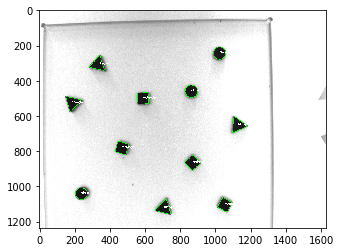

In [14]:
plt.imshow(output_image)
cv2.imwrite("detected_img.jpg", output_image)

In [ ]:
detections

In [ ]:
detect_array = np.array(detections, dtype="float32")

In [ ]:
M_cam = np.array([[1162, 572],
                  [1147, 901],
                  [1016, 279],
                  [235, 367],
                  [352, 1114]])

In [ ]:
M_cam

In [ ]:
Origin_robot = np.array([455.68, -165.10])

M_rob = np.array([[631.46, -37.56],
                  [628.74, 13.30],
                  [610.11, -84.14],
                  [490.24, -71.18],
                  [510.28, 45.66]]) - Origin_robot

In [ ]:
from sklearn import linear_model
clf = linear_model.Ridge()

In [ ]:
clf.fit(M_cam, M_rob)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
M_pred_ridge = clf.predict(M_cam)

In [ ]:
mean_squared_error(M_pred_ridge, M_rob)

In [ ]:
M_pred = clf.predict(detect_array[:, 1:])
M_pred

In [ ]:
detect_array[:, 1:] = clf.predict(detect_array[:, 1:])

In [ ]:
detect_bytes = ["{:.0f}{:0>7.2f}{:0>7.2f}".format(row[0], row[1], row[2]).encode()
                for row in detect_array]

In [ ]:
detect_bytes

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, 'model/coord_calib_ridge_regression.pkl')

In [ ]:
clf = joblib.load('model/clf.pkl')